<a href="https://colab.research.google.com/github/HireTheHero/Machine_Notebooks/blob/main/ProbFlow_Collective_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ProbFlow Examples w/ Multiple Models
- [Linear Regression](https://probflow.readthedocs.io/en/latest/examples/linear_regression.html)
- [Mixed Effect Model](https://probflow.readthedocs.io/en/latest/examples/lme.html)

# init

In [1]:
# !pip install -q tensorflow==2.0.0
# !pip install -q tensorflow-probability==0.8.0
!pip install -q --upgrade git+https://github.com/brendanhasz/probflow.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import torch

import probflow as pf

%config InlineBackend.figure_format = 'svg'
sns.set()
seed = 12345
np.random.seed(seed)
tf.random.set_seed(seed)

randn = lambda *x: np.random.randn(*x).astype('float32')

pf.set_backend('pytorch')

In [3]:
# https://qiita.com/north_redwing/items/1e153139125d37829d2d
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

# Linear Regression

## Simple Linear Regression

A simple linear regression is one of the simplest ([discriminative](https://en.wikipedia.org/wiki/Discriminative_model)) Bayesian models - it's just fitting a line to some data points!  Suppose we have some data for which we have the $x$ values, and we want to predict the $y$ values:

Text(0, 0.5, 'y')

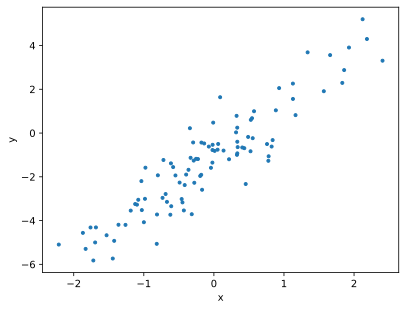

In [ ]:
# Generate some data
x = randn(100)
w = 2
b = -1
y = w*x + b + randn(100)

# Plot it
plt.plot(x, y, '.')
plt.xlabel('x')
plt.ylabel('y')

With a Bayesian regression, we predict the expected value using two parameters: the slope ($w$) and the intercept ($b$) of the fit line.  Then, we model the datapoints as being drawn from a normal distribution (with standard deviation $\sigma$) centered at that expected value.

$$
y \sim \text{Normal}(wx+b, ~ \sigma)
$$

To create this model with ProbFlow, we'll create an instance of the [`ContinuousModel`](https://probflow.readthedocs.io/en/latest/api_models.html#probflow.models.ContinuousModel) class (because our target variable is continuous).  In the `__init__` method, we'll define the parameters of the model.  Then in the `__call__` method, we'll use samples from those parameters to generate probabilistic predictions.

In [ ]:
class SimpleLinearRegression(pf.ContinuousModel):

    def __init__(self):
        self.w = pf.Parameter(name='Weight')
        self.b = pf.Parameter(name='Bias')
        self.s = pf.ScaleParameter(name='Std')
        self.backend = pf.get_backend()

    def __call__(self, x):
        if self.backend == 'pytorch':
            x = torch.tensor(x)
        return pf.Normal(x*self.w()+self.b(), self.s())

After defining the model class, we just need to create an instance of the model, and then we can fit it to the data using stochastic variational inference!

In [ ]:
model = SimpleLinearRegression()
model.fit(x, y, epochs=200, lr=0.2)

<ipython-input-45-e48ab959b49e>:11: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = torch.tensor(x)
<ipython-input-45-e48ab959b49e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1116: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps.1 : Float(1, strides=[1], requires_grad=0, device=cpu) = aten::normal(%43, %50, %51) # /usr/local/lib/python3.10/dist-packages/torch/distributions/utils.py:59:0
	%eps : Float(1, strides=[1], requires_grad=0, device

Now that we've fit the model, we can use it to make predictions on some test data:

<ipython-input-45-e48ab959b49e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


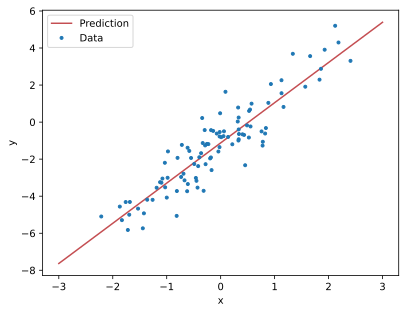

In [ ]:
# Make predictions
x_test = np.array([-3, 3]).astype('float32')
preds = model.predict(x_test)

# Plot em
plt.plot(x_test, preds, 'r', label='Prediction')
plt.plot(x, y, '.', label='Data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Or view the residuals of the model's predictions (the difference between the actual and predicted values):

<ipython-input-45-e48ab959b49e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


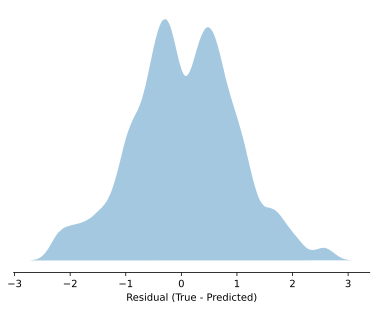

In [ ]:
sns.reset_orig()
model.residuals_plot(x, y)

Since this is a probabilistic model, we can also look at the posterior distributions of our parameters (that is, the probability distributions over what the model thinks the true values of the parameters are):

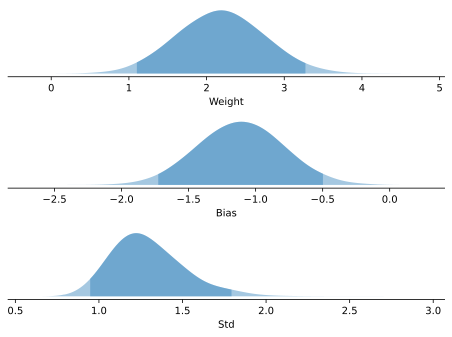

In [ ]:
model.posterior_plot(ci=0.95)

We can also get the model's confidence intervals on its predictions:

<ipython-input-45-e48ab959b49e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


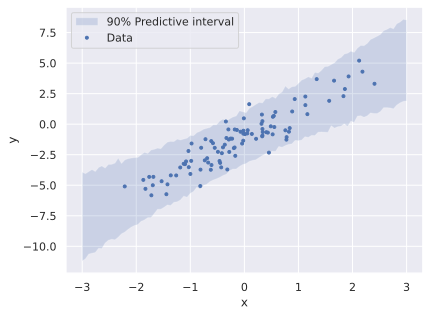

In [ ]:
sns.set()

# Compute 95% predictive confidence intervals
x_eval = np.linspace(-3, 3, 100).astype('float32')
lb, ub = model.predictive_interval(x_eval, ci=0.9)

# Plot em
plt.fill_between(x_eval, lb, ub, alpha=0.2,
                 label='90% Predictive interval')
plt.plot(x, y, '.', label='Data')
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Or on just a single datapoint:

<ipython-input-45-e48ab959b49e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


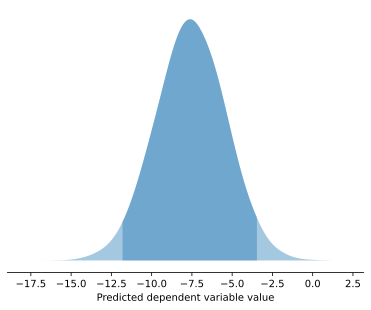

In [ ]:
sns.reset_orig()

model.pred_dist_plot(x_eval[:1], ci=0.95)

Or draw sample predictions from the model:

<ipython-input-45-e48ab959b49e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


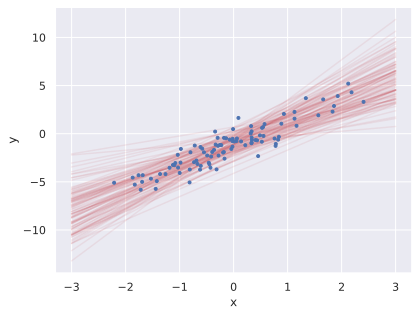

In [ ]:
sns.set()

# Draw sample fits from the model
x_eval = np.array([-3, 3]).astype('float32')
samples = model.predictive_sample(x_eval, n=100)

# Plot em
x_plot = np.broadcast_to(x_eval[:, np.newaxis], samples.T.shape)
plt.plot(x_plot, samples.T, 'r', alpha=0.1)
plt.plot(x, y, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

And view the [Bayesian R-squared distribution](https://doi.org/10.1080/00031305.2018.1549100)!

<ipython-input-45-e48ab959b49e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


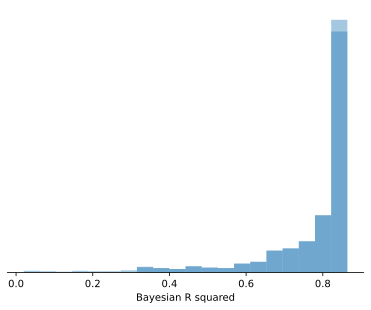

In [ ]:
sns.reset_orig()

model.r_squared_plot(x, y, ci=0.95)

## Multiple Linear Regression

A multiple linear regression is when we have multiple features (independent variables), and a single target (dependent variable).  It's just like a simple linear regression, except each feature gets its own weight:

$$
y \sim \text{Normal}(x_1 w_1 + x_2 w_2 + \dots + x_N w_N + b, ~ \sigma)
$$

or, if we represent the features and weights as vectors:

$$
y \sim \text{Normal}(\mathbf{x}^\top \mathbf{w} + b, ~ \sigma)
$$

Let's generate a dataset with multiple features.  Also, we'll store the data in a [Pandas](https://pandas.pydata.org/) DataFrame to see how ProbFlow works with Pandas!

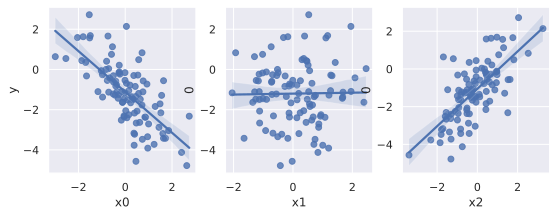

In [ ]:
sns.set()

# Settings
D = 3
N = 100

# Generate some data
x = pd.DataFrame(randn(N, D))
#weights = randn(D, 1)
weights = np.array([[-1], [0], [1]]).astype('float32')
y = x @ weights - 1 + 0.2*randn(N, 1)

# Plot em
plt.figure(figsize=(9, 3))
for i in range(D):
    plt.subplot(1, D, i+1)
    sns.regplot(x=x[i], y=y[0])
    plt.xlabel('x'+str(i))
    if i == 0:
        plt.ylabel('y')

We can create pretty much the same model as before, except we'll create $\mathbf{w}$ as a vector parameter, and because our input is now a pandas DataFrame, we'll call `df.values` to get the underlying numpy array.  Also note that below we're using the `@` operator, which is the [infix operator for matrix multiplication](https://www.python.org/dev/peps/pep-0465/).

In [ ]:
class MultipleLinearRegression(pf.ContinuousModel):#x = torch.tensor(x)

    def __init__(self, dims):
        self.w = pf.Parameter([dims, 1], name='Weights')
        self.b = pf.Parameter(name='Bias')
        self.s = pf.ScaleParameter(name='Std')
        self.backend = pf.get_backend()

    def __call__(self, x):
        if self.backend == 'pytorch':
            x_values = torch.tensor(x.values)
        else:
            x_values = x.values
        return pf.Normal(x_values @ self.w() + self.b(), self.s())

Again, just instantiate the model and fit it to the data.  You can control the learning rate and the number of epochs used to fit the data with the `lr` and `epochs` keyword arguments:

In [ ]:
model = MultipleLinearRegression(3)
model.fit(x, y, lr=0.1, epochs=900)

And again we can view the posterior distributions for our parameters, but this time our weight parameter is a vector with three elements, so each has an independent posterior:

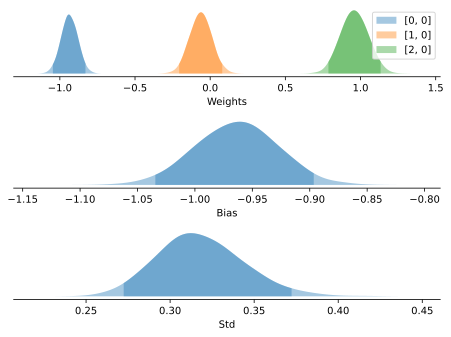

In [ ]:
sns.reset_orig()

model.posterior_plot(ci=0.95)

## Using the Dense Module

The [`Dense`](https://probflow.readthedocs.io/en/latest/api_modules.html#probflow.modules.Dense) module can also be used to build a linear regression:

In [ ]:
class LinearRegression(pf.ContinuousModel):

    def __init__(self, dims):
        self.layer = pf.Dense(dims, 1)
        self.s = pf.ScaleParameter()
        self.backend = pf.get_backend()

    def __call__(self, x):
        if self.backend == 'pytorch':
            x_values = torch.tensor(x.values)
        else:
            x_values = x
        return pf.Normal(self.layer(x.values), self.s())

# Fit it!
model = LinearRegression(3)
model.fit(x, y, lr=0.1, epochs=300)

## Using the LinearRegression Model

But the easiest way to do a linear regression with ProbFlow is to use the pre-built [`LinearRegression`](https://probflow.readthedocs.io/en/latest/api_applications.html#probflow.applications.LinearRegression) model!

In [ ]:
model = pf.LinearRegression(3)
model.fit(x, y, lr=0.1, epochs=300)

## Using the MultivariateNormalParameter

So far, our parameters have been completely independent.  We might want to model the full joint distribution, to allow for a potential correlation between the parameters.  For that, we can use [`MultivariateNormalParameter`](https://probflow.readthedocs.io/en/latest/api_parameters.html#probflow.parameters.MultivariateNormalParameter), which creates a parameter that has a multivariate normal posterior, with full covariance.  We'll index the parameter in `__call__`, which automatically takes a slice from a sample of the parameter


In [ ]:
class LinearRegression(pf.ContinuousModel):

    def __init__(self, dims):
        self.betas = pf.MultivariateNormalParameter(dims+2)

    def __call__(self, x):
        x = torch.tensor(x.values)
        w = self.betas[:-2]
        b = self.betas[-2]
        s = torch.nn.Softplus()(self.betas[-1])
        return pf.Normal(x @ w + b, s)

In [ ]:
class LinearRegression(pf.ContinuousModel):

    def __init__(self, dims):
        self.betas = pf.MultivariateNormalParameter(dims+2)

    def __call__(self, x):
        w = self.betas[:-2]
        b = self.betas[-2]
        s = tf.nn.softplus(self.betas[-1])
        return pf.Normal(x.values @ w + b, s)

In [ ]:
class LinearRegression(pf.ContinuousModel):

    def __init__(self, dims):
        self.betas = pf.MultivariateNormalParameter(dims+2)
        self.backend = pf.get_backend()

    def __call__(self, x):
        if self.backend == 'pytorch':
            x_values = torch.tensor(x.values)
            s = torch.nn.Softplus()(self.betas[-1])
        else:
            x_values = x.values
            s = tf.nn.softplus(self.betas[-1])
        w = self.betas[:-2]
        b = self.betas[-2]
        return pf.Normal(x_values @ w + b, s)

model = LinearRegression(3)
model.fit(x, y, lr=0.1, epochs=300)

Now the covariance between parameters has also been modeled:

Text(0, 0.5, 'b')

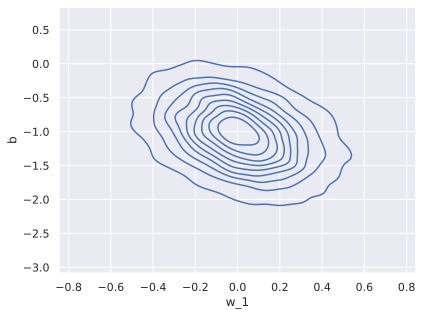

In [ ]:
samples = model.betas.posterior_sample(n=10000)
sns.kdeplot(x=samples[:, 1, 0], y=samples[:, 3, 0])
plt.xlabel('w_1')
plt.ylabel('b')

# Mixed Effect

## Data Preparation

In [52]:
n_samples = 100
n_groups = 5
group_size = n_samples // n_groups

# Creating data for groups, individuals, and some continuous predictors
data = {
    'group': np.repeat(range(n_groups), group_size),
    'age': np.random.normal(30, 10, n_samples),  # age of individuals
    'height': np.random.normal(170, 10, n_samples),  # height of individuals
}

df = pd.DataFrame(data)

# Simulate a response variable 'y' with both fixed and random components
fixed_effect_age = 0.5
fixed_effect_height = 1.5
random_effect_std_group = 5.0
random_effect_std_individual = 10.0

# Random effects for groups and individuals
group_effects = np.random.normal(0, random_effect_std_group, n_groups)
intercept = 0
intercept_std = 5

df['y'] = (fixed_effect_age * df['age'] +
           fixed_effect_height * df['height'] +
           group_effects[df['group']] +
           np.random.normal(intercept, intercept_std, n_samples))  # Add some measurement noise

In [53]:
df2 = df.merge(pd.get_dummies(df["group"], prefix="group").astype(int), left_index=True, right_index=True).drop("group", axis=1)
df2[df2.columns[df2.columns.str.contains("group")]]

,group_0,group_1,group_2,group_3,group_4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
95,0,0,0,0,1
96,0,0,0,0,1
97,0,0,0,0,1
98,0,0,0,0,1


In [4]:
# n_samples = 100
# n_groups = 5
# group_size = n_samples // n_groups

# # Creating data for groups, individuals, and some continuous predictors
# data = {
#     'group': np.repeat(range(n_groups), group_size),
#     'age': np.random.normal(30, 10, n_samples),  # age of individuals
#     'height': np.random.normal(170, 10, n_samples),  # height of individuals
# }

# df = pd.DataFrame(data)

# # Simulate a response variable 'y' with both fixed and random components
# fixed_effect_age = 0.5
# random_effect_std_group = 5.0
# random_effect_std_individual = 10.0

# # Random effects for groups and individuals
# group_effects = np.random.normal(0, random_effect_std_group, n_groups)
# individual_effects = np.random.normal(0, random_effect_std_individual, n_samples)

# df['y'] = (fixed_effect_age * df['age'] +
#            group_effects[df['group']] +
#            individual_effects +
#            np.random.normal(0, 5, n_samples))  # Add some measurement noise

In [54]:
df_train, df_test = train_test_split(df2, test_size=0.3, random_state=seed)

## Mixed Effect Model (official)

In [55]:
features = ['age', 'height']+list(df_train.columns[df_train.columns.str.contains('group')])

In [56]:
class LinearMixedEffectsModel(pf.Model):

    def __init__(self, Nf, Nr):
        self.Nf = Nf
        self.w = pf.Parameter([Nf, 1])
        self.u = pf.Parameter([Nr, 1])
        self.sigma = pf.ScaleParameter([1, 1])
        self.backend = pf.get_backend()

    def __call__(self, x):
        if self.backend == 'pytorch':
            x = torch.tensor(x, dtype=torch.float32)
        X = x[:, :self.Nf]
        Z = x[:, self.Nf:]
        return pf.Normal(X @ self.w() + Z @ self.u(), self.sigma())

In [57]:
df_train[features].head()

,age,height,group_0,group_1,group_2,group_3,group_4
6,23.541419,184.412451,1,0,0,0,0
54,27.088278,174.708862,0,0,1,0,0
71,42.737680,160.462739,0,0,0,1,0
52,28.559718,177.153593,0,0,1,0,0
30,36.143505,176.182836,0,1,0,0,0


In [58]:
model = LinearMixedEffectsModel(Nf=2, Nr=5)
model.fit(df_train[features].values, df_train['y'].values, epochs=1000, lr=0.01)

<ipython-input-56-8c5bf9690a2d>:12: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = torch.tensor(x, dtype=torch.float32)
<ipython-input-56-8c5bf9690a2d>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1116: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps.1 : Float(2, 1, strides=[1, 1], requires_grad=0, device=cpu) = aten::normal(%67, %75, %76) # /usr/local/lib/python3.10/dist-packages/torch/distributions/utils.py:59:0
	%eps

In [59]:
print("Ground Truth")
print([fixed_effect_age, fixed_effect_height])
print(group_effects)
print("=========")
print("Predicted")
print(model.w())
print(model.u())

Ground Truth
[0.5, 1.5]
[ 0.66722666  1.63952304  0.36076572  0.6583881  -6.48729621]
Predicted
Parameter containing:
tensor([[0.6026],
        [1.4841]], requires_grad=True)
Parameter containing:
tensor([[1.4242],
        [2.4360],
        [1.1914],
        [2.2100],
        [2.7047]], requires_grad=True)


<ipython-input-56-8c5bf9690a2d>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


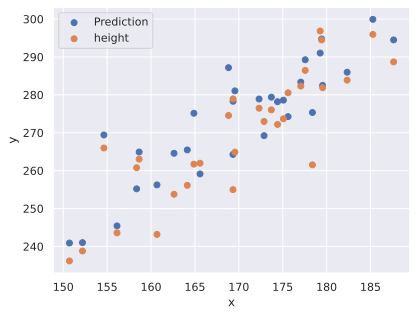

In [61]:
# Make predictions
x_test = df_test[features].values
# x_test = np.array([-3, 3]).astype('float32')
y_test = df_test['y'].values
preds = model.predict(x_test)

feature_idx = 1
# Plot em
# plt.plot(x_test, preds, 'r', label='Prediction')
# plt.plot(preds, 'r', label='Prediction')
plt.scatter(x_test[:,feature_idx], preds, label='Prediction')
plt.scatter(x_test[:,feature_idx], y_test, label=features[feature_idx])
# plt.plot(x_test, y_test, '.', label='Data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()